In [ ]:
!pip install mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 36.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import cv2
import mediapipe as mp
import numpy as np
from google.colab import drive
from torchvision.transforms import RandomRotation

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, base_dirs, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        self.rotation_multiplicity = 5  # Each image will be considered 5 times
        closed_hand_labels = {'Fist'}

        for base_dir in base_dirs:
            print(f"Loading data from {base_dir}...")
            for dir_name in os.listdir(base_dir):
                full_dir_path = os.path.join(base_dir, dir_name)
                if os.path.isdir(full_dir_path):
                    label = 0 if dir_name in closed_hand_labels else 1
                    self.load_images_from_folder(full_dir_path, label)

    def load_images_from_folder(self, folder, label):
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            if os.path.isfile(img_path):
                for _ in range(self.rotation_multiplicity):
                    self.data.append(img_path)
                    self.labels.append(label)
        print(f"Loaded and augmented {len(self.data)} images from {folder}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transformations = transforms.Compose([
    transforms.Resize((128, 128)),
    RandomRotation((-180, 180)),  # Random rotation of the image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # grayscale
])

base_dirs = [
    '/content/drive/MyDrive/bw_hand',
]

dataset = CustomDataset(base_dirs, transform=transformations)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

Loading data from /content/drive/MyDrive/bw_hand...
Loaded and augmented 960 images from /content/drive/MyDrive/bw_hand/Blank
Loaded and augmented 3355 images from /content/drive/MyDrive/bw_hand/Five
Loaded and augmented 4340 images from /content/drive/MyDrive/bw_hand/Fist
Loaded and augmented 8265 images from /content/drive/MyDrive/bw_hand/Yo
Loaded and augmented 10685 images from /content/drive/MyDrive/bw_hand/Two
Loaded and augmented 13235 images from /content/drive/MyDrive/bw_hand/ThumbsUp


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # Adjusted for 1 channel input
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)  # Adjust dimension if needed
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


    # Simple training loop
    for epoch in range(epochs):
        print("Epoch", epoch)
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}", end="\r")
        print(f'\nEpoch {epoch+1} complete, Average Loss: {running_loss/len(train_loader):.4f}')

    print("Training complete!")

# for saving
def save_model(model, filename='model_bw.pth'):
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")




In [ ]:
model = SimpleCNN()
epochs = 45 # set epochs
train_model(model, train_loader, epochs)
save_model(model)

In [ ]:
esave_model(model,"/content/drive/MyDrive/modelv1.pth")

Model saved to /content/drive/MyDrive/modelv1.pth


# Testing the model

In [ ]:
model = SimpleCNN()
model.load_state_dict(torch.load("/content/drive/MyDrive/modelv1.pth"))

<All keys matched successfully>

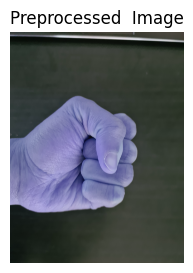

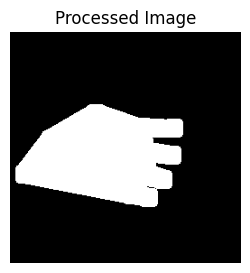

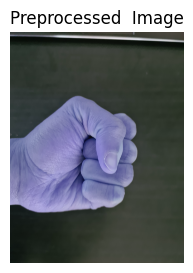

Processed k2-closed - Copy (4).jpg: Hand is CLOSED


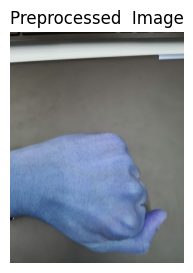

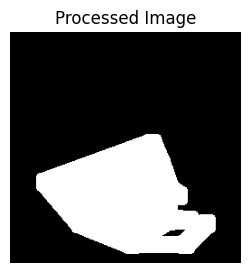

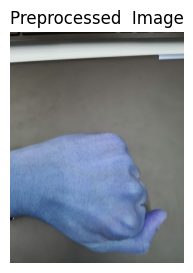

Processed 20240512_190426 - Copy (48).jpg: Hand is CLOSED


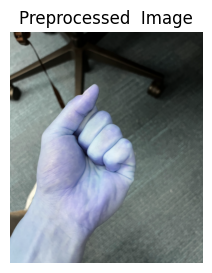

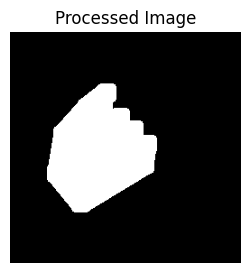

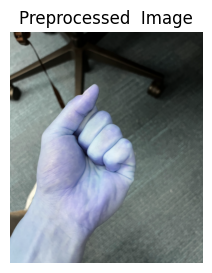

Processed Screenshot 2024-05-14 at 2.49.58 PM.png: Hand is CLOSED


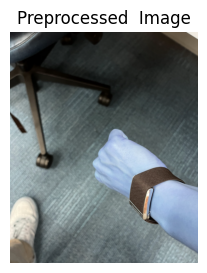

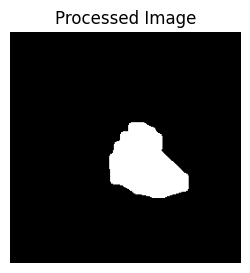

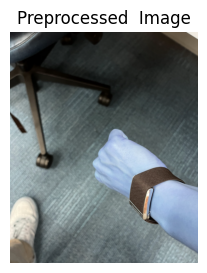

Processed Screenshot 2024-05-14 at 2.50.51 PM.png: Hand is CLOSED


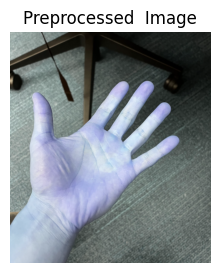

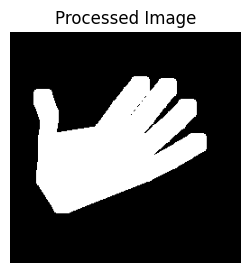

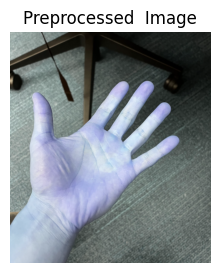

Processed Screenshot 2024-05-14 at 2.50.57 PM.png: Hand is OPEN


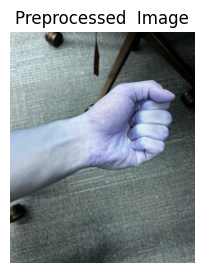

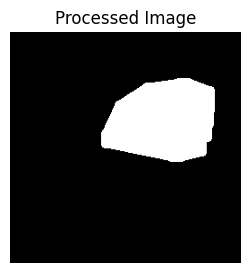

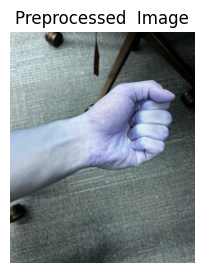

Processed Screenshot 2024-05-14 at 2.52.18 PM.png: Hand is CLOSED


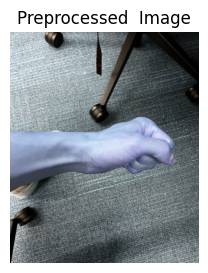

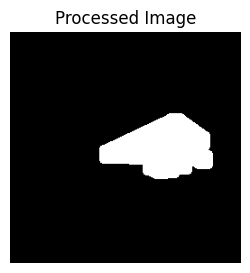

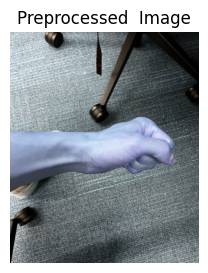

Processed Screenshot 2024-05-14 at 2.52.24 PM.png: Hand is OPEN


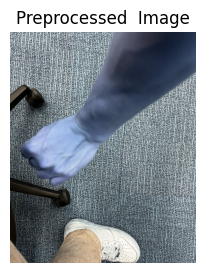

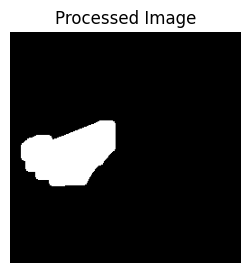

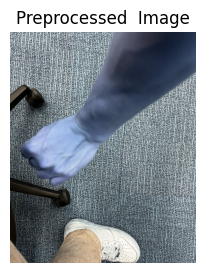

Processed Screenshot 2024-05-14 at 3.02.55 PM.png: Hand is OPEN


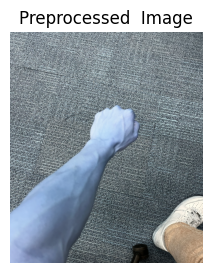

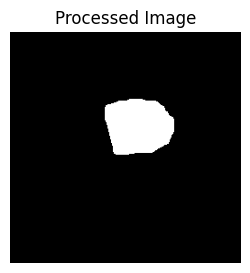

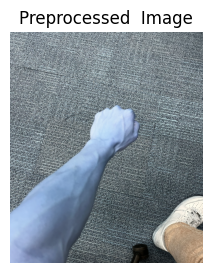

Processed Screenshot 2024-05-14 at 3.03.19 PM.png: Hand is CLOSED


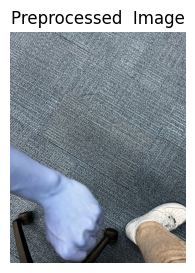

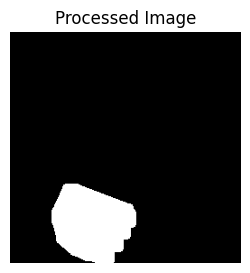

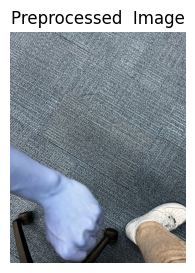

Processed Screenshot 2024-05-14 at 3.03.29 PM.png: Hand is OPEN


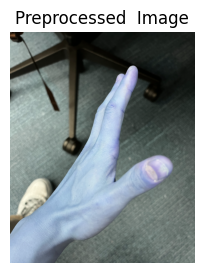

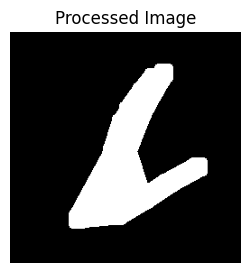

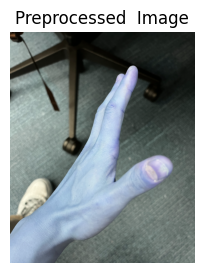

Processed Screenshot 2024-05-14 at 3.03.39 PM.png: Hand is OPEN


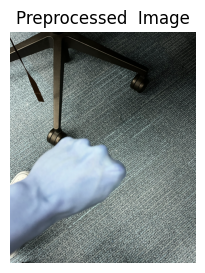

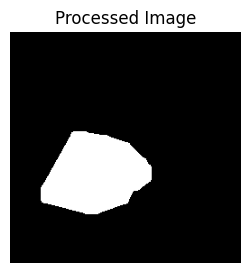

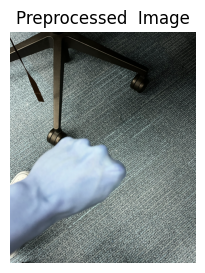

Processed Screenshot 2024-05-14 at 3.03.50 PM.png: Hand is CLOSED


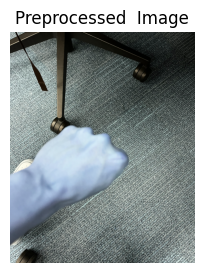

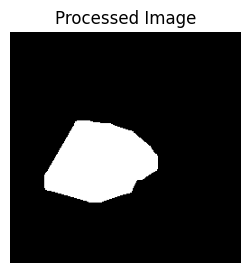

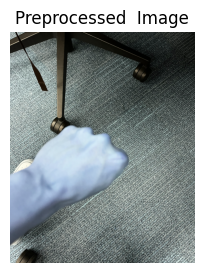

Processed Screenshot 2024-05-14 at 3.03.58 PM.png: Hand is CLOSED


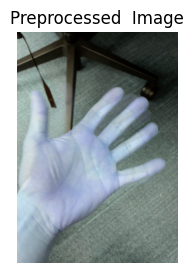

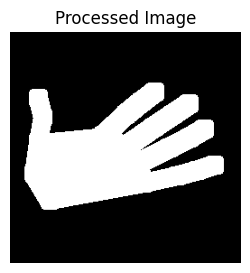

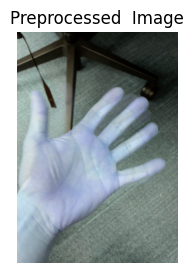

Processed Screenshot 2024-05-14 at 3.04.21 PM.png: Hand is OPEN


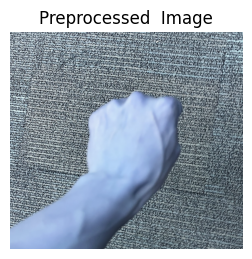

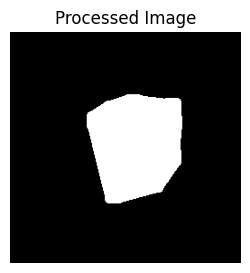

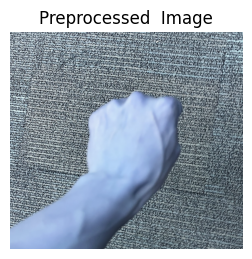

Processed Screenshot 2024-05-14 at 3.14.07 PM.png: Hand is CLOSED


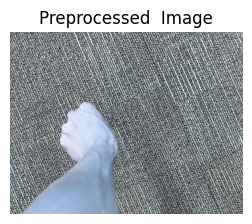

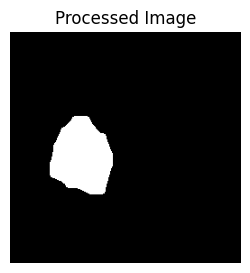

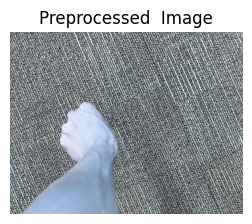

Processed Screenshot 2024-05-14 at 3.14.19 PM.png: Hand is OPEN


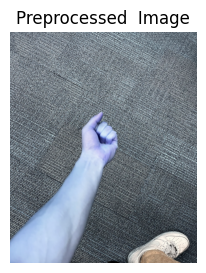

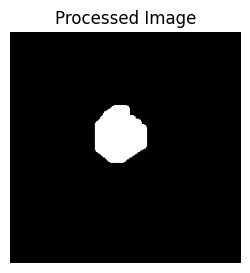

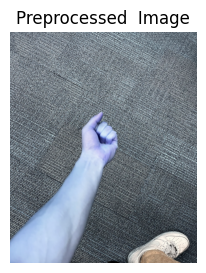

Processed Screenshot 2024-05-14 at 3.14.24 PM.png: Hand is CLOSED


In [ ]:
import matplotlib.pyplot as plt
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
def process_image(image):
    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe Hands
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        results = hands.process(image)

        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]

            h, w, _ = image.shape
            x_min = int(min([lm.x for lm in hand_landmarks.landmark]) * w)
            x_max = int(max([lm.x for lm in hand_landmarks.landmark]) * w)
            y_min = int(min([lm.y for lm in hand_landmarks.landmark]) * h)
            y_max = int(max([lm.y for lm in hand_landmarks.landmark]) * h)

            cropped_image = image[y_min:y_max, x_min:x_max]
            cropped_image = cv2.resize(cropped_image, (256, 256))

            # Create a single-channel mask
            mask = np.zeros(cropped_image.shape[:2], dtype=np.uint8)

            # Convert single-channel mask to BGR
            mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

            # Draw landmarks on the BGR mask
            mp_drawing.draw_landmarks(
                mask_bgr,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2),
                mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=4)
            )

            landmarks = [lm for lm in hand_landmarks.landmark]
            adjusted_landmarks = [(int(lm.x * 256), int(lm.y * 256)) for lm in landmarks]
            palm = [adjusted_landmarks[i] for i in [0, 2, 5, 9, 13, 17]]
            cv2.fillPoly(mask_bgr, [np.array(palm, dtype=np.int32)], 255)


            # Extract the single-channel mask from BGR mask
            mask = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)

            kernel = np.ones((15, 15), np.uint8)
            mask = cv2.dilate(mask, kernel, iterations=1)

            # Create a complete black and white image where the hand is white
            # hand_image = np.zeros_like(cropped_image)
            hand_image = np.zeros(cropped_image.shape[:2], dtype=np.uint8)  # Note change here: shape and dtype

            hand_image[mask > 0] = 255  # All channels to 255 where mask is white
    # Display the processed hand image
            plt.figure(figsize=(3, 3))
            plt.imshow(hand_image, cmap='gray')  # Ensure it is displayed as grayscale
            plt.title(f"Processed Image")
            plt.axis('off')
            plt.show()
            return hand_image

        else:
            return None

def test_model(model, directory):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    results = []

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        image = cv2.imread(file_path)
        if image is None:
            continue
        plt.figure(figsize=(3, 3))
        plt.imshow(image, cmap='gray')  # Ensure it is displayed as grayscale
        plt.title(f"Preprocessed  Image")
        plt.axis('off')
        plt.show()

        hand_image = process_image(image)
        if hand_image is None:
            print(f"No hand detected in {filename}.")
            continue
        hand_image = cv2.resize(hand_image, (128, 128))
        plt.figure(figsize=(3, 3))
        plt.imshow(hand_image, cmap='gray')  # Ensure it is displayed as grayscale
        plt.title(f"Postprocessed  Image")
        plt.axis('off')
        plt.show()
        # Convert to PIL for compatibility with torchvision transforms
        hand_image = Image.fromarray(hand_image)
        hand_image = transform(hand_image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(hand_image)
            predicted = torch.argmax(output, dim=1).item()


        results.append((filename, predicted))
        final_str = "CLOSED" if predicted ==  0 else "OPEN"
        print(f"Processed {filename}: Hand is {final_str}")

    return results
test_results = test_model(model, '/content/drive/MyDrive/test_hands')
# Example Usage:
